In [1]:
import pycaret
import pandas as pd

In [2]:
# อ่านไฟล์ CSV
data = pd.read_csv('export_data/filtered_data_3_best.csv')

In [3]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [4]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")

row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


humidity       82.889367
pm_10          60.525519
pm_2_5         53.415241
pm_2_5_sp      69.527667
temperature    29.219760
Name: 2023-09-30 07:00:00, dtype: float64

<Axes: xlabel='timestamp'>

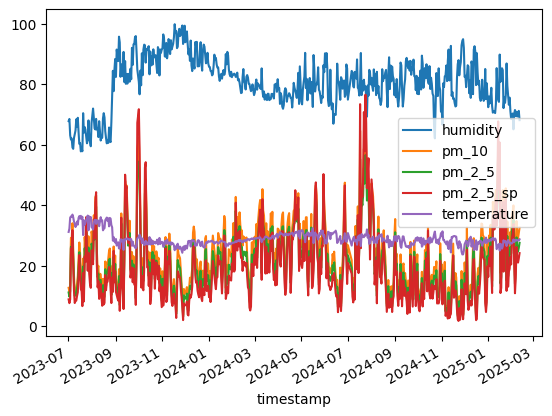

In [5]:
data.plot()

In [6]:
data_a = data[['pm_2_5', 'humidity', 'temperature']]

In [7]:
data_a["year"] = data_a.index.year
data_a["month"] = data_a.index.month
data_a["day"] = data_a.index.day
data_a["day_of_week"] = data_a.index.dayofweek  # 0 = Monday, 6 = Sunday
data_a["week_of_year"] = data_a.index.isocalendar().week  # ค่าจะเป็น int64

In [8]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data_a["season"] = data_a.index.month.map(assign_season)
data_a['season'] = data_a['season'].map(season_mapping)

In [9]:
data_a['dew_point'] = data_a['temperature'] - ((100 - data_a['humidity']) / 5)
data_a["is_weekend"] = data_a.index.dayofweek.isin([5, 6]).astype(int)

In [10]:
data_a["temp_humidity_ratio"] = data_a["temperature"] / (data_a["humidity"] + 1)

In [11]:
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data_a["temperature"]
RH = data_a["humidity"]

data_a["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

In [12]:
# ความชื้นสัมพัทธ์เชิงดัชนี
data_a["rh_index"] = data_a["humidity"] ** 2 / (data_a["temperature"] + 1)

In [13]:
import pandas as pd
import numpy as np

# สมมุติว่ามี data_aFrame data_a ที่มีข้อมูลอยู่แล้ว

# เพิ่มฟีเจอร์ day_of_year
data_a['date'] = pd.to_datetime(data_a[['year', 'month', 'day']])
data_a['day_of_year'] = data_a['date'].dt.dayofyear

# เพิ่มฟีเจอร์ hour_of_day (สมมุติว่าเป็นข้อมูลที่มีชั่วโมง)
# หากไม่มีข้อมูลชั่วโมงใน data_a, อาจต้องใส่ฟีเจอร์นี้เพิ่มเติม
# data_a['hour_of_day'] = data_a['hour']

# เพิ่มฟีเจอร์ is_holiday (สามารถกำหนดเองได้)
# สมมุติว่าคุณมีรายชื่อวันหยุดในปีนั้นๆ
# holidays = ['2025-01-01', '2025-12-25']  # ตัวอย่าง
# data_a['date'] = pd.to_datetime(data_a[['year', 'month', 'day']])
# data_a['is_holiday'] = data_a['date'].isin(pd.to_datetime(holidays))

# เพิ่มฟีเจอร์ month_sin และ month_cos
data_a['month_sin'] = np.sin(2 * np.pi * data_a['month'] / 12)
data_a['month_cos'] = np.cos(2 * np.pi * data_a['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data_a['day_of_week_sin'] = np.sin(2 * np.pi * data_a['day_of_week'] / 7)
data_a['day_of_week_cos'] = np.cos(2 * np.pi * data_a['day_of_week'] / 7)

# เพิ่มฟีเจอร์ rolling average (ค่าเฉลี่ยเคลื่อนที่)
data_a['pm_2_5_rolling_7'] = data_a['pm_2_5'].rolling(window=7).mean().shift(1)
data_a['pm_2_5_rolling_10'] = data_a['pm_2_5'].rolling(window=10).mean().shift(1)
data_a['pm_2_5_rolling_14'] = data_a['pm_2_5'].rolling(window=14).mean().shift(1)
data_a['pm_2_5_rolling_18'] = data_a['pm_2_5'].rolling(window=18).mean().shift(1)
data_a['pm_2_5_rolling_20'] = data_a['pm_2_5'].rolling(window=20).mean().shift(1)
data_a['pm_2_5_rolling_24'] = data_a['pm_2_5'].rolling(window=24).mean().shift(1)
data_a['pm_2_5_rolling_30'] = data_a['pm_2_5'].rolling(window=30).mean().shift(1)

data_a['pm_2_5_lag_7'] = data_a['pm_2_5'].shift(7)
data_a['pm_2_5_lag_10'] = data_a['pm_2_5'].shift(10)
data_a['pm_2_5_lag_14'] = data_a['pm_2_5'].shift(14)
data_a['pm_2_5_lag_18'] = data_a['pm_2_5'].shift(18)
data_a['pm_2_5_lag_20'] = data_a['pm_2_5'].shift(20)
data_a['pm_2_5_lag_24'] = data_a['pm_2_5'].shift(24)
data_a['pm_2_5_lag_30'] = data_a['pm_2_5'].shift(30)

data_a['humidity_rolling_2'] = data_a['humidity'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
data_a['humidity_rolling_3'] = data_a['humidity'].rolling(window=3).mean().shift(1)  # ค่าเฉลี่ย 3 วันของ PM 10
data_a['humidity_rolling_5'] = data_a['humidity'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
data_a['humidity_rolling_7'] = data_a['humidity'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data_a['humidity_lag_1'] = data_a['humidity'].shift(1)
data_a['humidity_lag_2'] = data_a['humidity'].shift(2)
data_a['humidity_lag_3'] = data_a['humidity'].shift(3)
data_a['humidity_lag_5'] = data_a['humidity'].shift(5)
data_a['humidity_lag_7'] = data_a['humidity'].shift(7)

data_a['temperature_rolling_2'] = data_a['temperature'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
data_a['temperature_rolling_3'] = data_a['temperature'].rolling(window=3).mean().shift(1)  # ค่าเฉลี่ย 3 วันของ PM 10
data_a['temperature_rolling_5'] = data_a['temperature'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
data_a['temperature_rolling_7'] = data_a['temperature'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data_a['temperature_lag_1'] = data_a['temperature'].shift(1)
data_a['temperature_lag_2'] = data_a['temperature'].shift(2)
data_a['temperature_lag_3'] = data_a['temperature'].shift(3)
data_a['temperature_lag_5'] = data_a['temperature'].shift(5)
data_a['temperature_lag_7'] = data_a['temperature'].shift(7)

data_a["temp_diff"] = data_a["temperature"].diff()
data_a["humidity_diff"] = data_a["humidity"].diff()

data_a.dropna(subset=["pm_2_5_rolling_30"], inplace=True)  # ลบแถวที่ไม่มีค่า PM2.5 Last Week
# data_a['humidity_rolling'] = data_a['humidity'].rolling(window=5).mean()  # ค่าเฉลี่ย 7 วันของความชื้น
# data_a['temperature_rolling'] = data_a['temperature'].rolling(window=5).mean()

# # ตรวจสอบว่า data_aFrame พร้อมใช้งานแล้ว
# print(data_a.head())


In [14]:
data_filtered = data_a.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป
data_filtered.head(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,temperature_rolling_3,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-01 07:00:00,13.813822,82.476224,28.787466,2023,9,1,4,35,2,25.282711,...,28.368976,29.20755,30.709105,27.617516,28.059126,29.430287,32.680964,35.538801,1.16995,-5.941398


In [15]:
data_a.head()

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,temperature_rolling_3,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-07-31 07:00:00,27.245125,67.144508,32.747292,2023,7,31,0,31,1,26.176194,...,36.032586,35.265371,35.306029,36.060490,35.766286,36.270982,36.546776,35.160224,-3.313198,7.632546
2023-08-01 07:00:00,26.451635,69.591363,32.488559,2023,8,1,1,31,2,26.406831,...,34.858023,34.505474,34.961324,32.747292,36.060490,35.766286,31.682319,35.655124,-0.258733,2.446856
2023-08-02 07:00:00,21.880753,71.994422,31.969049,2023,8,2,2,31,2,26.367934,...,33.765447,34.666722,34.508958,32.488559,32.747292,36.060490,36.270982,36.546776,-0.519510,2.403059
2023-08-03 07:00:00,32.360223,68.958755,34.327104,2023,8,3,3,31,2,28.118855,...,32.401633,33.806335,33.854997,31.969049,32.488559,32.747292,35.766286,31.682319,2.358055,-3.035668
2023-08-04 07:00:00,28.656228,65.430435,35.098487,2023,8,4,4,31,2,28.184574,...,32.928237,33.518499,34.232823,34.327104,31.969049,32.488559,36.060490,36.270982,0.771383,-3.528320


In [16]:
from pycaret.time_series import *
exp1 = TSForecastingExperiment()
# ตั้งค่าของ PyCaret
s = exp1.setup(data=data_filtered, target='pm_2_5', fh=7, session_id=123)

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(530, 54)"
5,Transformed data shape,"(530, 54)"
6,Transformed train set shape,"(523, 54)"
7,Transformed test set shape,"(7, 54)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [17]:
# compare baseline models
best = exp1.compare_models(n_select=17)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
croston,Croston,1.1219,0.9425,7.8939,8.8802,0.3460,0.2845,-0.0264,0.0200


In [18]:
exp1.predict_model(best)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Croston,0.6771,0.7027,4.8275,6.7056,0.2705,0.2055,-0.8597


,y_pred
2025-02-05,28.382
2025-02-06,28.382
2025-02-07,28.382
2025-02-08,28.382
2025-02-09,28.382
2025-02-10,28.382
2025-02-11,28.382


In [19]:
best = create_model('auto_arima')

ValueError: _CURRENT_EXPERIMENT global variable is not set. Please run setup() first.

In [ ]:
tune = create_model(best)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.0146,0.0147,0.1005,0.1357,0.0099,0.0100,0.9993
1,2024-11-13,0.0220,0.0227,0.1489,0.2056,0.0137,0.0136,0.9990
2,2024-12-13,0.0363,0.0371,0.2457,0.3356,0.0152,0.0150,0.9989
Mean,NaT,0.0243,0.0248,0.1651,0.2256,0.0130,0.0129,0.9991
SD,NaT,0.0090,0.0093,0.0604,0.0828,0.0023,0.0021,0.0002


# NEW

In [ ]:
model_1 = create_model('ridge_cds_dt')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.0407,0.0345,0.2806,0.3182,0.0280,0.0284,0.9960
1,2024-11-13,0.0556,0.0502,0.3759,0.4554,0.0416,0.0432,0.9950
2,2024-12-13,0.0771,0.0732,0.5222,0.6626,0.0272,0.0277,0.9958
Mean,NaT,0.0578,0.0527,0.3929,0.4787,0.0323,0.0331,0.9956
SD,NaT,0.0149,0.0159,0.0994,0.1416,0.0066,0.0071,0.0004


In [ ]:
model_2 = create_model('rf_cds_dt')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.9124,0.8234,6.2832,7.5920,0.8254,0.4757,-1.2683
1,2024-11-13,0.8430,0.7334,5.7017,6.6512,0.7432,0.4812,-0.0679
2,2024-12-13,1.2412,1.1042,8.4081,9.9920,0.5505,0.4525,0.0436
Mean,NaT,0.9988,0.8870,6.7977,8.0784,0.7064,0.4698,-0.4309
SD,NaT,0.1737,0.1579,1.1632,1.4066,0.1152,0.0125,0.5939


In [ ]:
blend = blend_models([model_1, model_2])

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.9362,0.8383,6.4473,7.7293,0.8560,0.4851,-1.3511
1,2024-11-13,0.8226,0.7415,5.5635,6.7242,0.7032,0.4764,-0.0915
2,2024-12-13,1.2014,1.0695,8.1385,9.6779,0.5501,0.4370,0.1028
Mean,NaT,0.9867,0.8831,6.7164,8.0438,0.7031,0.4662,-0.4466
SD,NaT,0.1587,0.1376,1.0683,1.2262,0.1249,0.0209,0.6445


In [ ]:
tune = tune_model(blend)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-10-14,0.8603,0.7802,5.9249,7.1939,0.7941,0.4595,-1.0367
1,2024-11-13,0.8298,0.7688,5.6128,6.9719,0.6802,0.4891,-0.1734
2,2024-12-13,1.2343,1.1029,8.3618,9.9795,0.5426,0.4511,0.0460
Mean,NaT,0.9748,0.8840,6.6332,8.0484,0.6723,0.4666,-0.3880
SD,NaT,0.1839,0.1549,1.2289,1.3685,0.1028,0.0163,0.4674


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.6s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    7.9s finished


In [ ]:
plot_model(best, plot = 'forecast')

# TEST

In [ ]:
final_best = finalize_model(best)

In [ ]:
# # สร้าง timestamp ตั้งแต่วันที่ 12 กุมภาพันธ์ 2025 ไปจนถึง 30 วันถัดไป
# start_date = pd.to_datetime("2025-02-12")
# date_range = pd.date_range(start=start_date, periods=30, freq='D')

# # สร้าง DataFrame ที่มีแค่ timestamp เป็น index
# new_data_index_only = pd.DataFrame(index=date_range)
# new_data_index_only

In [ ]:
data_test = pd.read_csv('export_data/output_test.csv')
data_test.index = data_test['Unnamed: 0']
data_test.drop(columns=['Unnamed: 0'], inplace=True)
data_test = data_test.rename_axis('timestamp')

data_test.index = pd.to_datetime(data_test.index)

data_test

,temperature,humidity,year,month,day,day_of_week,week_of_year,temp_humidity_ratio
timestamp,,,,,,,,
2025-01-13,27.6430,79.6041,2025,1,13,0,3,0.342948
2025-01-14,27.8771,79.0661,2025,1,14,1,3,0.348176
2025-01-15,28.4779,75.2929,2025,1,15,2,3,0.373271
2025-01-16,27.7895,76.1709,2025,1,16,3,3,0.360103
2025-01-17,28.2242,76.5904,2025,1,17,4,3,0.363759
2025-01-18,27.9305,76.4994,2025,1,18,5,3,0.360396
2025-01-19,27.5031,74.3674,2025,1,19,6,3,0.364920
2025-01-20,27.9924,71.6042,2025,1,20,0,4,0.385548
2025-01-21,28.0390,74.3681,2025,1,21,1,4,0.372027


In [ ]:
# ถ้า index เป็น PeriodIndex, แปลงเป็น DatetimeIndex
if isinstance(data_test.index, pd.PeriodIndex):
    data_test.index = data_test.index.to_timestamp()

# ตรวจสอบประเภทของ index ใหม่
print(data_test.index)

DatetimeIndex(['2025-01-13', '2025-01-14', '2025-01-15', '2025-01-16',
               '2025-01-17', '2025-01-18', '2025-01-19', '2025-01-20',
               '2025-01-21', '2025-01-22', '2025-01-23', '2025-01-24',
               '2025-01-25', '2025-01-26', '2025-01-27', '2025-01-28',
               '2025-01-29', '2025-01-30', '2025-01-31', '2025-02-01',
               '2025-02-02', '2025-02-03', '2025-02-04', '2025-02-05',
               '2025-02-06', '2025-02-07', '2025-02-08', '2025-02-09',
               '2025-02-10', '2025-02-11'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


In [ ]:
data.columns

Index(['humidity', 'pm_10', 'pm_2_5', 'pm_2_5_sp', 'temperature'], dtype='object')

In [ ]:
data_test.columns

Index(['temperature', 'humidity', 'year', 'month', 'day', 'day_of_week',
       'week_of_year', 'temp_humidity_ratio'],
      dtype='object')

In [ ]:
predict_model(final_best, X=data_test)

TypeError: Invalid comparison between dtype=datetime64[ns] and Period